In [41]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import tensorflow as tf
from tensorflow import keras
import keras.layers as tfl
import seaborn as sn
import dataset

In [19]:
# All mfcc data are contained in numpy_datas, which is a list. 
# The each entry of the list is another list consistes of [mfccs, file name]
MFCCs_DATA = "MFCCsData"
numpy_datas = []

dirlist = os.listdir(MFCCs_DATA)
for d in dirlist:
    d = os.path.join(MFCCs_DATA, d)
    datalist = os.listdir(d)
    datalist = [[np.load(os.path.join(d,x)), os.path.join(d,x)] for x in datalist]
    numpy_datas.extend(datalist)

In [20]:
numpy_datas[200][0].shape

(19, 612)

In [21]:
numpy_datas[100][0].shape

(19, 492)

Notice that the size of mfccs for each emotion file is different, need to resize the data into the same size

In [22]:
# resize into (19,512) then transpose to (512,19) for CNN
for i in range(len(numpy_datas)):
    numpy_datas[i][0] = np.transpose(np.resize(numpy_datas[i][0], (19,512)))

In [23]:
numpy_datas[200][0].shape

(512, 19)

In [24]:
numpy_datas[100][0].shape

(512, 19)

So now all data has the same shape

Separate the data list according to the label. Change file name to correct label. [1,0,0] is angry, [0,1,0] is happy, [0,0,1] is normal.

In [25]:
# change file name to correct label
angry = []
happy = []
normal = []

for i in range(len(numpy_datas)):
    file_name = numpy_datas[i][1]
    if "angry" in file_name:
        numpy_datas[i][1] = np.array([1,0,0])
        angry.append(numpy_datas[i])
    elif "happy" in file_name:
        numpy_datas[i][1] = np.array([0,1,0])
        happy.append(numpy_datas[i])
    else:
        numpy_datas[i][1] = np.array([0,0,1])
        normal.append(numpy_datas[i])

Now split the Train-Valid-Test data with a ratio of 60%-20%-20%

In [26]:
# first shuffle the list of each emotion
random.shuffle(angry)
random.shuffle(happy)
random.shuffle(normal)

In [27]:
# then select the first 180 in each emotion as train data, first 60 in each emotion as valid data, and first 60 in each emotion as test data
train_data = angry[:int(len(angry)*0.6)] + happy[:int(len(happy)*0.6)] + normal[:int(len(normal)*0.6)]
valid_data = angry[int(len(angry)*0.6):int(len(angry)*(0.6+0.2))] + happy[int(len(happy)*0.6):int(len(happy)*(0.6+0.2))] + normal[int(len(normal)*0.6):int(len(normal)*(0.6+0.2))]
test_data = angry[int(len(angry)*(0.6+0.2)):] + happy[int(len(happy)*(0.6+0.2)):] + normal[int(len(normal)*(0.6+0.2)):]
random.shuffle(train_data)
random.shuffle(valid_data)
random.shuffle(test_data)

In [28]:
# train, valid, test data are all in list consistes of [mfccs, file name]
# want to change the list to two outputs:
# X: vector of mfccs
# Y: vector of labels
def data2vector(data):
    X = []
    Y = []
    for i in range(len(data)):
        X.append(data[i][0])
        Y.append(data[i][1])
    X = np.array(X)
    Y = np.array(Y)
    return X,Y

In [29]:
X_train, Y_train = data2vector(train_data)

In [30]:
print(X_train.shape)
print(Y_train.shape)

(540, 512, 19)
(540, 3)


In [31]:
X_valid, Y_valid = data2vector(valid_data)
X_test, Y_test = data2vector(test_data)

Now let's do normalization, by the value of train data

In [137]:
X_train_miu = np.average(X_train, axis=0)
X_train_std = np.std(X_train, axis=0)

In [77]:
print(X_train_miu.shape)
print(X_train_std.shape)

(512, 19)
(512, 19)


In [66]:
print(np.average(X_train, axis=0).shape)

(512, 19)


In [111]:
X_train_norm = (X_train - X_train_miu)/X_train_std
X_valid_norm = (X_valid - X_train_miu)/X_train_std
X_test_norm = (X_test - X_train_miu)/X_train_std

Integrated part for dataset preprocessing and splitting

In [7]:
# interfacce function to get splited dataset
dataset_collection = dataset.getMFCCDataset(train_size = 0.6, valid_size = 0.2, test_size = 0.2)

X_train = dataset_collection['X_train']
Y_train = dataset_collection['Y_train']
X_valid = dataset_collection['X_valid']
Y_valid = dataset_collection['Y_valid']
X_test = dataset_collection['X_test']
Y_test = dataset_collection['Y_test']

X_train_norm = dataset_collection['X_train_norm']
X_valid_norm = dataset_collection['X_valid_norm']
X_test_norm = dataset_collection['X_test_norm']

In [8]:
# convert array to tensor
X_train_norm = tf.convert_to_tensor(X_train_norm)
X_valid_norm = tf.convert_to_tensor(X_valid_norm)
X_test_norm = tf.convert_to_tensor(X_test_norm)
Y_train = tf.convert_to_tensor(Y_train)
Y_valid = tf.convert_to_tensor(Y_valid)
Y_test = tf.convert_to_tensor(Y_test)

X_train = tf.convert_to_tensor(X_train)
X_valid = tf.convert_to_tensor(X_valid)
X_test = tf.convert_to_tensor(X_test)

In [60]:
print(X_train_norm.shape)

(540, 512, 19)


In [38]:
# flatten the shape
#X_train_norm_flat = tf.reshape(X_train_norm, [540, -1])
#X_valid_norm_flat = tf.reshape(X_valid_norm, [180, -1])
#X_test_norm_flat = tf.reshape(X_test_norm, [180, -1])

In [9]:
def convolutional_model(input_shape):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> Softmax -> MAXPOOL -> FLATTEN -> DENSE
    
    Arguments:
    input_mfcc -- input dataset, of shape (input_shape)

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """

    input_mfcc = tf.keras.Input(shape=input_shape)
    ## CONV1D: 4 filters 8, stride of 1, padding 'SAME'
    Z1 = tfl.Conv1D(filters = 4, kernel_size = 8, strides = 2, padding='same', kernel_initializer = 'he_normal', kernel_regularizer = 'L1')(input_mfcc)
    ## RELU
    A1 = tfl.ReLU()(Z1)
    ## MAXPOOL: window 8, stride 4, padding 'SAME'
    P1 = tfl.MaxPool1D(pool_size = 8, strides = 4, padding='same')(A1)
    
    ## CONV1D: 2 filters 4, stride 1, padding 'SAME'
    Z2 = tfl.Conv1D(filters = 4, kernel_size = 4, strides = 2, padding='same', kernel_initializer = 'he_normal', kernel_regularizer = 'L1')(P1)
    ## RELU
    A2 = tfl.Softmax()(Z2)
    ## MAXPOOL: window 4, stride 2, padding 'SAME'
    P2 = tfl.MaxPool1D(pool_size = 4, strides = 2, padding='same')(A2)
    ## FLATTEN
    F = tfl.Flatten()(P2)
    ## Dense layer
    ## 6 neurons in output layer. Hint: one of the arguments should be "activation='softmax'" 
    outputs = tfl.Dense(3, activation='softmax')(F)
    
    model = tf.keras.Model(inputs=input_mfcc, outputs=outputs)
    return model

In [10]:
conv_model = convolutional_model((512, 19))
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 19)]         0         
                                                                 
 conv1d (Conv1D)             (None, 256, 4)            612       
                                                                 
 re_lu (ReLU)                (None, 256, 4)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 64, 4)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 32, 4)             68        
                                                                 
 softmax (Softmax)           (None, 32, 4)             0         
                                                             

In [11]:
history = conv_model.fit(X_train_norm, Y_train, epochs=200, validation_data=(X_valid_norm, Y_valid))
# history2 = conv_model.fit(X_train, Y_train, epochs=100, validation_data=(X_valid, Y_valid))

Epoch 1/200
17/17 [==============================] - 3s 56ms/step - loss: 1.9441 - accuracy: 0.3148 - val_loss: 1.8402 - val_accuracy: 0.4111
Epoch 2/200
17/17 [==============================] - 0s 24ms/step - loss: 1.8212 - accuracy: 0.3481 - val_loss: 1.7742 - val_accuracy: 0.3722
Epoch 3/200
17/17 [==============================] - 0s 27ms/step - loss: 1.7590 - accuracy: 0.3630 - val_loss: 1.7283 - val_accuracy: 0.4167
Epoch 4/200
17/17 [==============================] - 0s 21ms/step - loss: 1.7092 - accuracy: 0.3889 - val_loss: 1.6835 - val_accuracy: 0.4056
Epoch 5/200
17/17 [==============================] - 0s 23ms/step - loss: 1.6615 - accuracy: 0.4185 - val_loss: 1.6386 - val_accuracy: 0.4333
Epoch 6/200
17/17 [==============================] - 1s 30ms/step - loss: 1.6118 - accuracy: 0.4481 - val_loss: 1.5903 - val_accuracy: 0.4667
Epoch 7/200
17/17 [==============================] - 0s 22ms/step - loss: 1.5559 - accuracy: 0.5037 - val_loss: 1.5292 - val_accuracy: 0.5111
Epoch 

E:\Anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

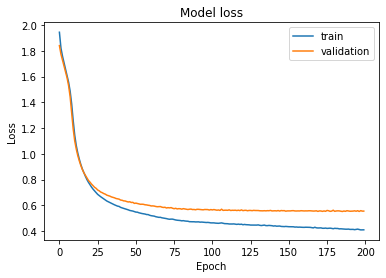

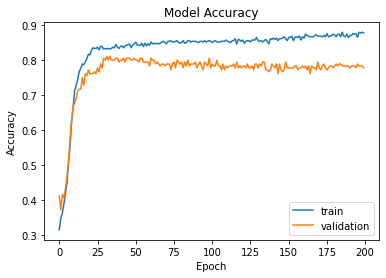

In [12]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(6,4)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(6,4)).set(xlabel='Epoch',ylabel='Accuracy')

6/6 [==============================] - 0s 7ms/step


[Text(0.5, 15.0, 'prediction'), Text(33.0, 0.5, 'actual')]

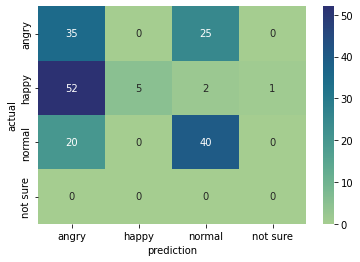

In [48]:
Y_pred = conv_model.predict(X_test)
Y_test_numpy = Y_test.numpy()
emotion_pred = []
emotion_test = []
for i in range(len(Y_pred)):
    if (Y_pred[i][0] > 0.5):
        emotion_pred.append(0) # angry
    elif (Y_pred[i][1] > 0.5):
        emotion_pred.append(1) # happy
    elif (Y_pred[i][2] > 0.5):
        emotion_pred.append(2) # normal
    else:
        emotion_pred.append(3) # not decided

    if (Y_test_numpy[i][0] > 0.5):
        emotion_test.append(0)
    elif (Y_test_numpy[i][1] > 0.5):
        emotion_test.append(1)
    elif (Y_test_numpy[i][2] > 0.5):
        emotion_test.append(2)

emotion_test = tf.convert_to_tensor(emotion_test)
emotion_pred = tf.convert_to_tensor(emotion_pred)

confusion = tf.math.confusion_matrix(emotion_test, emotion_pred, num_classes = 4)

df=pd.DataFrame(confusion.numpy(),index=['angry', 'happy', 'normal', 'not sure'],columns=['angry', 'happy', 'normal', 'not sure'])
confusiton_map = sn.heatmap(df,annot=True, cmap='crest')
confusiton_map.set(xlabel="prediction", ylabel="actual")